In [31]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

In [32]:
os.listdir("cifar-10-batches-py")

['batches.meta',
 'data_batch_1',
 'data_batch_2',
 'data_batch_3',
 'data_batch_4',
 'data_batch_5',
 'readme.html',
 'test_batch']

In [33]:
def unpickle(file): # File Path = "cifar-10-batches-py"
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [34]:
class MyDataset(Dataset):
    def __init__(self, tr = True):
        super().__init__()
        self.tr = tr
        if tr:
            self.lb = []
            self.data = []
            for i in range(5):
                self.data.append(unpickle(f"cifar-10-batches-py/data_batch_{i+1}")[b'data'])
                self.lb.append(unpickle(f"cifar-10-batches-py/data_batch_{i+1}")[b'labels'])
        else:
            self.data = unpickle("cifar-10-batches-py/test_batch")[b'data']
            self.lb = unpickle("cifar-10-batches-py/test_batch")[b'labels']
        
        self.data = np.array(self.data).reshape(-1, 3, 32, 32)
        # print(self.data.shape)
        self.lb = np.array(self.lb).reshape(-1,)
        # print(self.lb.shape)
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        data = self.data[idx]
        lb = self.lb[idx]
        return (data, lb)

In [35]:
train_dataset = MyDataset()
test_dataset = MyDataset(tr=False)
batch_sz = 64
train_loader = DataLoader(train_dataset, batch_size=batch_sz)
test_loader = DataLoader(test_dataset, batch_size=batch_sz)

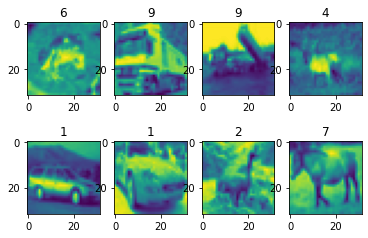

In [36]:
tl = iter(train_loader)

batch = next(tl)

# for batch in train_loader:
#     print(batch[0])
#     break

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(batch[0][i, 0, :, :])
    plt.title(batch[1][i].item())

In [37]:
device = torch.device("cuda")

In [9]:
# net = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1).to(device=device)

In [38]:
net = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1).to(device)                       

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to C:\Users\Khaly/.cache\torch\hub\checkpoints\resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [25]:
# net = models.googlenet(weights=models.GoogLeNet_Weights.IMAGENET1K_V1).to(device)

In [41]:
for params in net.parameters():
    params.requires_grad = False

In [42]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
net.fc = nn.Linear(in_features=2048, out_features=10, bias=True)

In [45]:
start_time = time.time()
net = net.to(device)

num_epochs = 200
lr = 0.05

opt = optim.Adam(net.parameters(), lr=lr)
schedular = optim.lr_scheduler.ExponentialLR(opt, 0.9)
ls = []
for i in range(num_epochs):
    epoch_start = time.time()
    total_loss = 0
    for batch in train_loader:
        X, y = batch[0].type(torch.FloatTensor).to(device), batch[1].type(torch.LongTensor).to(device)
        logits = net(X)
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    ls.append(total_loss)
    schedular.step()
    if ((i+1)%10) == 0:
        print(f"Epoch {i+1}/{num_epochs}: \nLoss= {ls[i]}\nTime: {time.time() - epoch_start}")
print(f"\n\nThe training Process has taken {(time.time() - start_time)/60} minutes")

Epoch 10/300: 
Loss= 4751.403703212738
Time: 54.398905515670776
Epoch 20/300: 
Loss= 2432.6313104629517
Time: 54.79487705230713
Epoch 30/300: 
Loss= 1534.4603633880615
Time: 54.33558964729309
Epoch 40/300: 
Loss= 1206.0473685264587
Time: 54.48885202407837
Epoch 50/300: 
Loss= 1083.7322563827038
Time: 54.97125482559204
Epoch 60/300: 
Loss= 1039.9511927068233
Time: 54.52050995826721
Epoch 70/300: 
Loss= 1024.1736915707588
Time: 55.48782706260681
Epoch 80/300: 
Loss= 1018.4498228430748
Time: 54.90743660926819
Epoch 90/300: 
Loss= 1016.4432311058044
Time: 53.926552534103394
Epoch 100/300: 
Loss= 1015.6821512281895
Time: 54.313982248306274
Epoch 110/300: 
Loss= 1015.3964503705502
Time: 55.609939098358154
Epoch 120/300: 
Loss= 1015.2940987944603
Time: 54.85115718841553
Epoch 130/300: 
Loss= 1015.2582343220711
Time: 54.59086036682129
Epoch 140/300: 
Loss= 1015.2458339929581
Time: 55.08230781555176
Epoch 150/300: 
Loss= 1015.2426202297211
Time: 55.718477725982666
Epoch 160/300: 
Loss= 1015.242

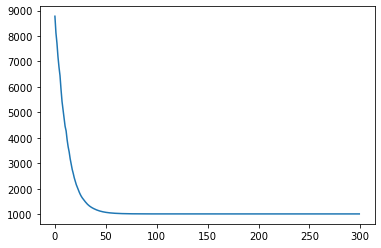

In [46]:
plt.plot(ls);

In [47]:
for params in net.parameters():
    params.requires_grad = True

In [ ]:
start_time = time.time()

num_epochs = 100
lr = 1e-4

opt = optim.Adam(net.parameters(), lr=lr)
schedular = optim.lr_scheduler.ExponentialLR(opt, 0.9)
ls = []
for i in range(num_epochs):
    epoch_start = time.time()
    total_loss = 0
    for batch in train_loader:
        X, y = batch[0].type(torch.FloatTensor).to(device), batch[1].type(torch.LongTensor).to(device)
        logits = net(X)
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    ls.append(total_loss)
    schedular.step()
    if (i%5) == 0:
        print(f"Epoch {i+1}/{num_epochs}: \nLoss= {ls[i]}\nTime: {time.time() - epoch_start}")
print(f"\n\nThe training Process has taken {(time.time() - start_time)/60} minutes")

Epoch 1/300: 
Loss= 1164.2523436546326
Time: 241.4370083808899
Epoch 6/300: 
Loss= 109.55363529827446
Time: 240.9619176387787
Epoch 11/300: 
Loss= 37.401331092463806
Time: 238.96019887924194
Epoch 16/300: 
Loss= 0.851861134923638
Time: 253.5597004890442
Epoch 21/300: 
Loss= 0.021241322910327654
Time: 245.84395503997803
Epoch 26/300: 
Loss= 0.005345381806364458
Time: 245.0577585697174
Epoch 31/300: 
Loss= 0.0013177634597525412
Time: 241.0219464302063
Epoch 36/300: 
Loss= 0.0003028769093162964
Time: 239.81955313682556
Epoch 41/300: 
Loss= 7.482242014944518e-05
Time: 245.4704988002777
Epoch 46/300: 
Loss= 6.707197042299384e-05
Time: 257.00061988830566
Epoch 51/300: 
Loss= 5.525908188719342e-05
Time: 239.53344583511353
Epoch 56/300: 
Loss= 4.277750152104076e-05
Time: 239.94311094284058
Epoch 61/300: 
Loss= 3.355182290709635e-05
Time: 247.294282913208
Epoch 66/300: 
Loss= 2.8368082441332376e-05
Time: 275.7877905368805
Epoch 71/300: 
Loss= 2.590007814529116e-05
Time: 271.715859413147
Epoch 7

In [ ]:
plt.plot(ls);

In [ ]:
net= net.to(device)
net.eval()
@torch.no_grad()
def test_accuracy(net, test_loader):
  average_acc = 0
  for batch in test_loader:
    X, y = batch[0].type(torch.FloatTensor).to(device),  batch[1].to(device)
    logits = net(X)
    labels = torch.argmax(logits, axis = 1)
    acc = torch.sum(labels == y, axis =0)/y.shape[0]
    average_acc+=acc

  print(average_acc/ len(test_loader))

test_accuracy(net, test_loader)